In [3]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [4]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [54]:
def into_cell(data, err, info_data, file, save_diagram, position):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
        
    lupmag = -np.arcsinh(data / 10 ** 3 / (2 * record["b_scale"] * err / 10 ** 3))
    err = np.absolute(-1 / (record["b_scale"] * err * np.sqrt((err / (record["b_scale"] * err)) ** 2 + 4)))
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    err = err / np.std(lupmag, ddof = 1, axis=0)

    som = record["som"]
    dim = record["dim"]

    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Topological error: {record["topo_err"]}")
    print(f"Quantization error: {record["quan_err"]}")
    
    if "prop_map" not in record:
        magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map.fill(np.nan)
        z_map = np.zeros(dim ** 2).reshape(dim, dim)
        z_map.fill(np.nan)
        labels_map = som.labels_map(proc_data, np.zeros_like(proc_data), tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
        for i in labels_map.keys():
            if i == position:
                properties = np.array(list(labels_map[position].keys()))
                plt.hist(properties[:,0], bins = 15, rwidth = 0.95)
                plt.xlabel("HSC i-band Magitude")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,0]), 5)} Median: {round(np.median(properties[:,0]), 5)} Std: {round(np.std(properties[:,0], ddof = 1), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,0]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,0]), c = "r", label = "median")
                plt.legend()
                plt.show()
                
                plt.close()
                plt.hist(properties[:,1], bins = 15, rwidth = 0.95)
                plt.xlabel("Spectroscopic Redshift")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,1]), 5)} Median: {round(np.median(properties[:,1]), 5)} Std: {round(np.std(properties[:,1], ddof = 1), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,1]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,1]), c = "r", label = "nedian")
                plt.legend()
                plt.show()
    
        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]
        for i in labels_map.keys():
            if i == position:
                properties = np.array(list(labels_map[position].keys()))
                plt.hist(properties[:,0], bins = 15, rwidth = 0.95)
                plt.xlabel("HSC i-band Magitude")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,0]), 5)} Median: {round(np.median(properties[:,0]), 5)} Std: {round(np.std(properties[:,0], ddof = 1), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,0]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,0]), c = "r", label = "median")
                plt.legend()
                plt.show()
                
                plt.close()
                plt.hist(properties[:,1], bins = 15, rwidth = 0.95)
                plt.xlabel("Spectroscopic Redshift")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,1]), 5)} Median: {round(np.median(properties[:,1]), 5)} Std: {round(np.std(properties[:,1], ddof = 1), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,1]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,1]), c = "r", label = "nedian")
                plt.legend()
                plt.show()

In [59]:
def std_map(data, err, info_data, file, save_diagram):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    dim = record["dim"]
        
    lupmag = -np.arcsinh(data / 10 ** 3 / (2 * record["b_scale"] * err / 10 ** 3))
    err = np.absolute(-1 / (record["b_scale"] * err * np.sqrt((err / (record["b_scale"] * err)) ** 2 + 4)))
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    err = err / np.std(lupmag, ddof = 1, axis=0)

    mag_std = np.zeros(dim ** 2).reshape(dim, dim)
    mag_std.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    som = record["som"]

    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Topological error: {record["topo_err"]}")
    print(f"Quantization error: {record["quan_err"]}")

    if "prop_map" not in record:
        labels_map = som.labels_map(proc_data, np.zeros_like(proc_data), tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
        for i in labels_map.keys():
            properties = np.std(np.array(list(labels_map[i].keys())), axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = properties[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = properties[1]

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (25, 10))
        plt.subplot(121)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("HSC i-band std")

        plt.subplot(122)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("Redshift std")
        
        plt.show()

        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]
        
        for i in labels_map.keys():
            properties = np.std(np.array(list(labels_map[i].keys())), axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = properties[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = properties[1]
        print(np.nanmean(z_std))

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (25, 10))
        plt.subplot(121)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("HSC i-band std")

        plt.subplot(122)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("Redshift std")

        plt.show()

In [60]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = data_all[0, 1::2]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11136\836707857.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


Topological error: 0.8189536098103292
Quantization error: 4.860283596387012
Topological error: 0.8189536098103292
Quantization error: 4.860283596387011


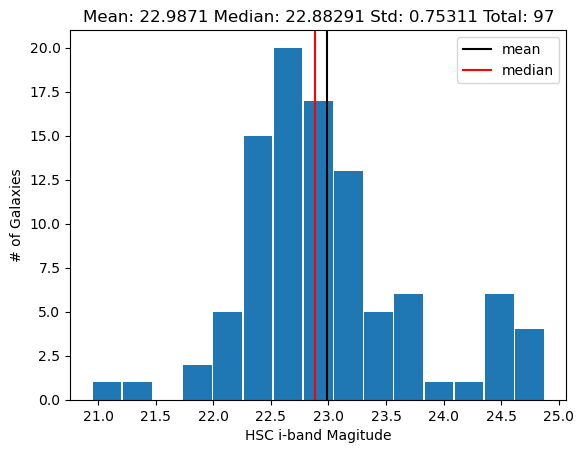

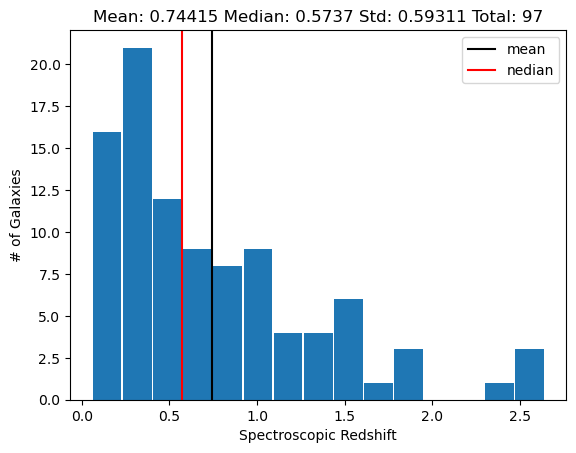

In [67]:
into_cell(data = data, err = err, info_data = info, position = (1, 1), file = "D:/SPHEREx_SOM/record/4th_exploration/SOM/chi2_lup_shallow_30_0.8_0.2_1000_2.pkl", save_diagram = True)

Topological error: 0.8189536098103292
Quantization error: 4.860283596387012
Topological error: 0.8189536098103292
Quantization error: 4.860283596387011
0.22010159465153495


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\_core\_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11136\2272989426.py:68: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11136\2272989426.py:73: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


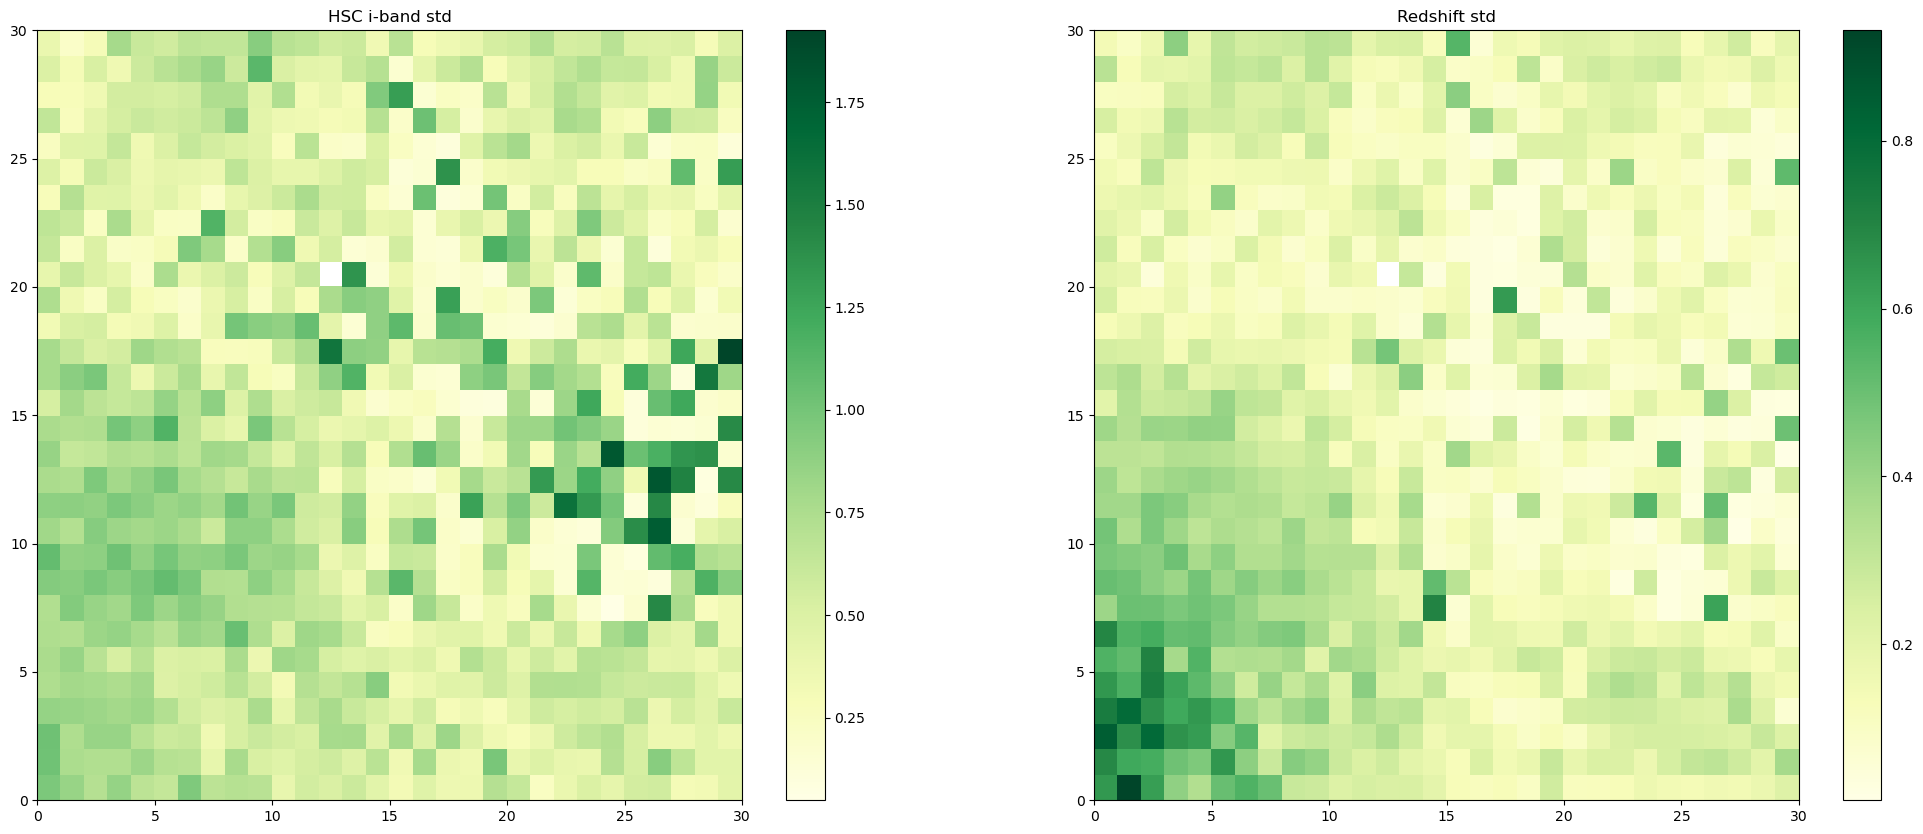

In [61]:
std_map(data = data, err = err, info_data = info, file = "D:/SPHEREx_SOM/record/4th_exploration/SOM/chi2_lup_shallow_30_0.8_0.2_1000_2.pkl", save_diagram = True)